In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import geopandas as gpd
import requests
from matplotlib.font_manager import FontProperties
%matplotlib widget

In [2]:
def radius(a,e):
    ra=a*(1+e)
    rb=a*(1-e)
    return ra,rb

def altitude(ra,rb,re):
    #on peut utiliser a et e
    za=ra-re
    zb=rb-re
    return za,zb

def periode(a,mu):
    T=2*np.pi*np.sqrt((a**3)/mu) #seconde, a et mu en km
    return T

def meanmotion(a,mu):
    mm=np.sqrt(mu/a**3)
    return mm

def vitesse(a,mu,r):
    V=np.sqrt(2*((mu/r)-(mu/(2*a))))   
    return V

def mean_anomaly(n=None,t=None,tp=None,E=None,e=None):
    if t==None:
        M=E-e*np.sin(E)
    else :
        M=n*(t-tp)
    return M

def critical_true_anomaly(e):
    vc=np.arccos(-e)
    return np.rad2deg(vc)

def correction(V,Vc,i):
    if -4*np.pi+Vc<=V<=-2*np.pi-Vc:
        corr=-3*np.pi
        sign=0 # signe -
    elif -2*np.pi-Vc<=V<=-2*np.pi+Vc:
        corr=-2*np.pi
        sign=1
    elif -2*np.pi+Vc<=V<=-Vc:
        corr=-np.pi
        sign=0
    elif -Vc<=V<=+Vc:
        corr=0
        sign=1
    elif Vc<=V<=2*np.pi-Vc:
        corr=np.pi
        sign=0
    elif 2*np.pi-Vc<=V<=2*np.pi+Vc:
        corr=2*np.pi
        sign=1
    else :
        corr=3*np.pi
        sign=1
    
    if i>90:
        return -corr,sign
    else : 
        return corr,sign
    
def correction_lon(w,V):
    if -w-360<V<=-w-270:
        cor=-2*np.pi
        sign=1
        #print(V,'cas 1')
    elif -w-270<V<=-90-w:
        cor=-np.pi
        sign=0
        #print(V,'cas 2')
    elif -90-w<V<=+90-w:
        cor=0
        sign=1
        #print(V,'cas 3')
    elif 90-w<V<=270-w:
        cor=np.pi
        sign=0
        #print(V,'cas 4')
    else :
        cor=2*np.pi
        sign=1
        #print(V,'cas 5')
    return cor,sign
    
def ttp(n,e,V,i)  :
    v=np.deg2rad(V)
    x=(np.sin(v)*np.sqrt(1-e**2))/(1+e*np.cos(v))
    Vc=np.deg2rad(critical_true_anomaly(e))
    cor,sign=correction(v,Vc,i)
    if sign==0:
        ttp=(1/n)*(cor-np.arcsin(x)-e*x)
    else :
        ttp=(1/n)*(cor+np.arcsin(x)-e*x)

        
    return ttp

def t(ttp,tp):
    t=ttp+tp
    return t

def latitude(w,V,i):
    V=np.deg2rad(V)
    w=np.deg2rad(w)
    i=np.deg2rad(i)
    la=np.arcsin(np.sin(w+V)*np.sin(i))
    return la

def longitude(w,V,i,la):
    corr,sign=correction_lon(w, V)
    if sign==0:
        lon=corr-np.arcsin(np.tan(np.deg2rad(la))/np.tan(np.deg2rad(i)))
    else :
        lon=corr+np.arcsin(np.tan(np.deg2rad(la))/np.tan(np.deg2rad(i)))
    return lon

def real_lon(lon,t,alpha,Lw):
    Ls=Lw+lon-alpha*t
    return Ls

In [3]:
def get_ls_la_lo_sate(data_float,data_str):      
    OBJECT_NAME=data_float[0]
    OBJECT_ID=data_float[1]
    EPOCH=data_float[2]
    MEAN_MOTION=float(data_float[3])
    ECCENTRICITY=float(data_float[4])
    INCLINATION=float(data_float[5])
    RA_OF_ASC_NODE=float(data_float[6])
    ARG_OF_PERICENTER=float(data_float[7])
    MEAN_ANOMALY=float(data_float[8])
    EPHEMERIS_TYPE=float(data_float[9])
    CLASSIFICATION_TYPE=data_float[10]
    NORAD_CAT_ID=float(data_float[11])
    ELEMENT_SET_NO=float(data_float[12])
    REV_AT_EPOCH=float(data_float[13])
    BSTAR=float(data_float[14])
    MEAN_MOTION_DOT=float(data_float[15])
    MEAN_MOTION_DDOT=data_float[16]
    UNIVERSAL_G=6.6743E-11
    EARTH_MASS=5.972E24 #kg
    T=(1/MEAN_MOTION)*24*60*60
    MEAN_MOTION_SI=2*np.pi/T
    MUE=398600.441
    RE=6378.0 #km
    ALPHA=360/86164
    SEMI_GRAND_AXIS=(MUE/(MEAN_MOTION_SI**2))**(1/3)
    RA,RP=radius(SEMI_GRAND_AXIS,ECCENTRICITY)
    ZA,ZB=altitude(RA,RP,RE)
    print(ZA,ZB)
    VA=vitesse(SEMI_GRAND_AXIS,MUE,RA)
    VP=vitesse(SEMI_GRAND_AXIS,MUE,RP)
    VC=critical_true_anomaly(ECCENTRICITY)
    W=ARG_OF_PERICENTER
    VW=-W
    LW=RA_OF_ASC_NODE
    n=(MUE/SEMI_GRAND_AXIS**3)**0.5
    
    list_V=np.arange(-180,180,1)
    list_T=np.zeros(len(list_V))
    list_la=np.zeros(len(list_V))
    list_lon=np.zeros(len(list_V))
    list_ls=np.zeros(len(list_V))
    tp=-ttp(MEAN_MOTION_SI,ECCENTRICITY,VC,INCLINATION)
    for j in range(len(list_V)):
        V=list_V[j]
        list_T[j]=t(ttp(MEAN_MOTION_SI,ECCENTRICITY,V,INCLINATION),tp)
        list_la[j]=np.rad2deg(latitude(W,V,INCLINATION))
        list_lon[j]=np.rad2deg(longitude(W,V,INCLINATION,list_la[j]))
        list_ls[j]=real_lon(list_lon[j],list_T[j],ALPHA,LW)
    name=OBJECT_NAME#+' '+OBJECT_ID
    Zmean = ZA+ZB
    return list_ls,list_la,list_lon,Zmean,name

548.3982248663215 546.2998441088721


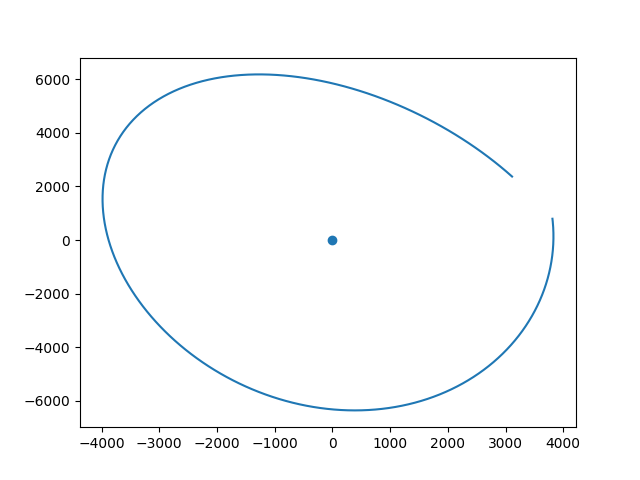

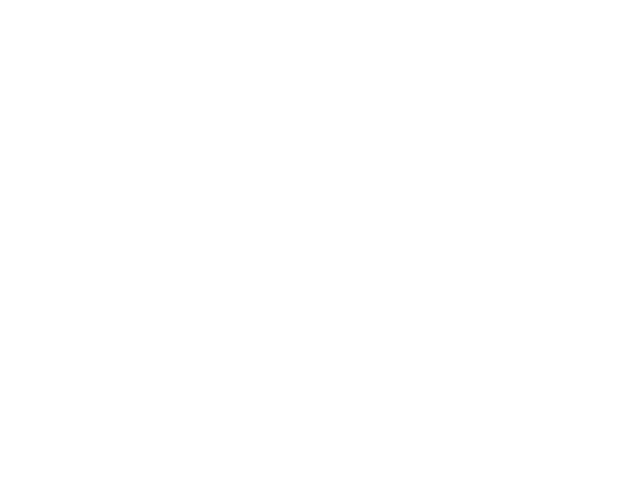

In [4]:
response = requests.get("https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=csv")
data = response.content.decode('utf-8')
lines = data.split('\n')
data_list = []
data_start,data_end=2051,2053
for line in lines:
    data_list.append(line.split(','))

data_str=data_list[0]
data_float=data_list[1:]
plt.figure(1)
#worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
#worldmap.plot(color="lightgrey")
for i in range(data_start+1,2053):
    list_ls,list_la,list_lon,Zmean,name=get_ls_la_lo_sate(data_float[i],data_str)
list_ls,list_la

rayon = 6371

x = rayon * np.cos( np.deg2rad(list_la) ) * np.cos( np.deg2rad(list_ls) );
y = rayon * np.cos( np.deg2rad(list_la) ) * np.sin ( np.deg2rad(list_ls) );

plt.figure(2)
plt.plot(x,y)
plt.scatter(0,0)
plt.show()   


548.588032488723 546.2181595492648


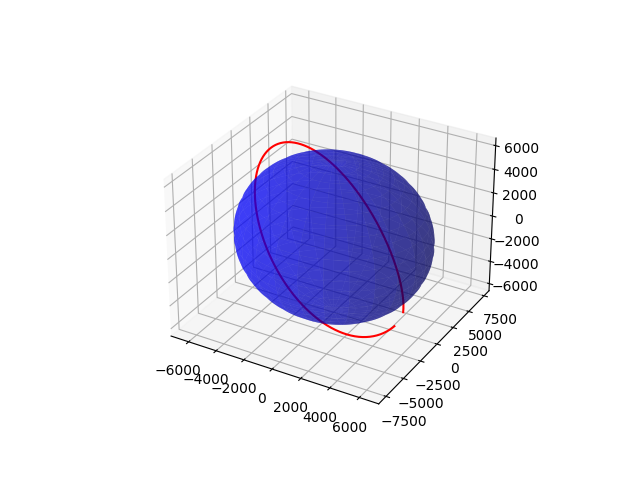

In [5]:



plt.cla
ax = plt.figure(3).add_subplot(projection='3d')
for i in range(2051,2052):
    list_ls,list_la,list_lon,Zmean,name=get_ls_la_lo_sate(data_float[i],data_str)
    Zmean =Zmean+ 6371
    x = Zmean * np.cos( np.deg2rad(list_la) ) * np.cos( np.deg2rad(list_ls) );
    y = Zmean * np.cos( np.deg2rad(list_la) ) * np.sin ( np.deg2rad(list_ls) );
    z= Zmean * np.sin( np.deg2rad(list_la) )
    ax.plot(x, y, z, label='ellipse',color='red')
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x2 = 6371 * np.outer(np.cos(u), np.sin(v))
y2 = 6371 * np.outer(np.sin(u), np.sin(v))
z2 = 6371 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x2, y2, z2, rstride=4, cstride=4, color='b',alpha=0.5)
plt.show()